In [ ]:
# python3.10 -m pip install s3fs==0.4.1
# python3.10 -m pip install fsspec==2023.6.0

In [ ]:
from datasets import load_dataset, DatasetDict, load_metric

import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments
from transformers import Trainer

import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, 
                             balanced_accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score)

import requests
from PIL import Image

from peft import LoraConfig, get_peft_model

model_name_or_path = 'google/vit-base-patch16-224-in21k'
dataset_path = 'postcards_train.csv'
images_path = '/home/jupyter/mnt/datasets/postcards'

In [665]:
df = pd.read_csv(dataset_path, index_col=0).reset_index(drop=True)
df["is_russian"] = df["is_russian"].apply(lambda x: int(x))
df = df[(df['Pic_url_1'] != 'Исходник недоступен') & (df['Pic_url_2'] != 'Исходник недоступен')]
df.head()

,Pic_url_1,Pic_url_2,is_russian,язык
0,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,0,иностранный язык
1,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,1,русский
2,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,1,русский
3,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,1,русский
4,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,1,русский


In [666]:
ds = Dataset.from_pandas(df)

ds_train_devtest = ds.train_test_split(test_size=0.2, seed=42)
ds_devtest = ds_train_devtest['test'].train_test_split(test_size=0.5, seed=42)

ds_splits = DatasetDict({
    'train': ds_train_devtest['train'],
    'valid': ds_devtest['train'],
    'test': ds_devtest['test']
})

In [667]:
ds_splits

DatasetDict({
    train: Dataset({
        features: ['Pic_url_1', 'Pic_url_2', 'is_russian', 'язык', '__index_level_0__'],
        num_rows: 29808
    })
    valid: Dataset({
        features: ['Pic_url_1', 'Pic_url_2', 'is_russian', 'язык', '__index_level_0__'],
        num_rows: 3726
    })
    test: Dataset({
        features: ['Pic_url_1', 'Pic_url_2', 'is_russian', 'язык', '__index_level_0__'],
        num_rows: 3727
    })
})

In [668]:
ds_splits['test'][0]

{'Pic_url_1': 'https://storage.yandexcloud.net/postcards-resize-880pix-tmp/27969970-4178-46f5-8217-26b63e39b985.jpg',
 'Pic_url_2': 'https://storage.yandexcloud.net/postcards-resize-880pix-tmp/ebfcf078-3ce9-455b-8349-3bd130daa7c4.jpg',
 'is_russian': 0,
 'язык': 'немецкий',
 '__index_level_0__': 3626}

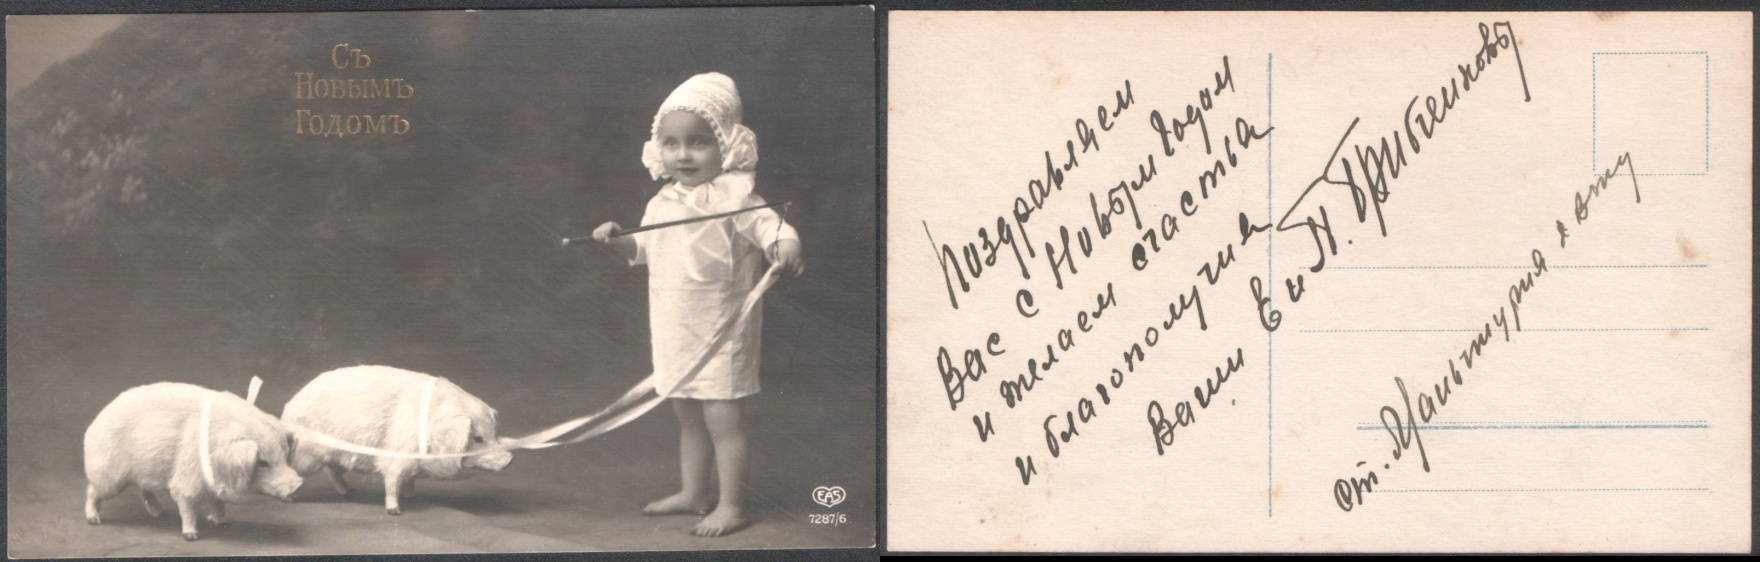

In [669]:
url_front = 'https://storage.yandexcloud.net/postcards-resize-880pix/104747-1-resize.jpg'
url_back = 'https://storage.yandexcloud.net/postcards-resize-880pix/104747-2-resize.jpg'

im_front = Image.open(os.path.join(images_path, url_front.rsplit('/')[-1]))
im_back = Image.open(os.path.join(images_path, url_back.rsplit('/')[-1]))

new_im = Image.new('RGB', (im_front.size[0] +  im_back.size[0], max(im_front.size[1], im_back.size[1])))

x_offset = 0
for im in [im_front, im_back]:
    new_im.paste(im, (x_offset, 0))
    x_offset += im.size[0]

new_im

In [670]:
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [671]:
def concat_images(im_name_front, im_name_back):
    im_front = Image.open(os.path.join(images_path, im_name_front))
    im_back = Image.open(os.path.join(images_path, im_name_back))

    new_im = Image.new('RGB', (im_front.size[0] +  im_back.size[0], max(im_front.size[1], im_back.size[1])))

    x_offset = 0
    for im in [im_front, im_back]:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
        
    return new_im

def transform(example_batch):
    inputs = processor([
        concat_images(
            url_front.rsplit('/')[-1], 
            url_back.rsplit('/')[-1]
        ) for url_front, url_back in zip(example_batch['Pic_url_1'], example_batch['Pic_url_2'])
    ], return_tensors='pt')
    
    inputs['labels'] = [x for x in example_batch['is_russian']]
    return inputs


In [ ]:
prepared_ds = ds_splits.with_transform(transform)

In [673]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [674]:
#!g1.1
def compute_metrics(output):
    labels = output.label_ids
    preds = np.array([[float(el1), float(el2)] for el1, el2 in output.predictions])
    preds = np.argmax(preds, axis=1)

    return {
        'eval_balanced_acc': balanced_accuracy_score(labels, preds),
        'eval_precision': precision_score(labels, preds),
        'eval_recall': recall_score(labels, preds),
        'eval_f1': f1_score(labels, preds)
    }

In [675]:
#!g1.1
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
#!g1.1
labels = [0, 1]

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
print_trainable_parameters(model)

In [ ]:
#!g1.1
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

In [648]:
#!g1.1
training_args = TrainingArguments(
    output_dir="./finetuned-lora-vit-base-v3",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    fp16=True,
    logging_steps=10,
    learning_rate=5e-3,
    gradient_accumulation_steps=4,
    metric_for_best_model="f1",
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    label_names=["labels"],
    seed=42,
)

In [ ]:
#!g1.1
trainer = Trainer(
    model=lora_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["valid"],
    tokenizer=processor,
)

In [ ]:
#!g1.1
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

In [676]:
#!g1.1
repo_name = "finetuned-lora-vit-base-v3"

In [ ]:
#!g1.1
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = ViTForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

inference_model = PeftModel.from_pretrained(model, repo_name)

In [678]:
#!g1.1
from tqdm.notebook import tqdm
import math

def gen_batch(records, batch_size):
    batch_start = 0
    while batch_start < len(records):
        batch_end = batch_start + batch_size
        batch = records[batch_start: batch_end]
        batch_start = batch_end
        yield batch


def get_predictions(test, model, batch_size=32):
    all_preds = []

    num_batches = math.ceil(len(test) / batch_size)

    for batch in tqdm(gen_batch(test, batch_size), total=num_batches, leave=True):
        encoding = batch['pixel_values']
    
        with torch.no_grad():
            outputs = inference_model(encoding)
            logits = outputs.logits

        predicted_class_idx = torch.argmax(logits, dim=-1)
        all_preds.extend(predicted_class_idx.detach().cpu().tolist())

    return all_preds

def print_metrics(labels, predictions):
    acc = accuracy_score(labels, predictions)
    bal_acc = balanced_accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {'accuracy': acc,
            'balanced accuracy': bal_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1}

In [679]:
#!g1.1
print_trainable_parameters(inference_model)

trainable params: 3076 || all params: 86391556 || trainable%: 0.00


In [680]:
#!g1.1
preds = get_predictions(prepared_ds['test'], inference_model, batch_size=32)

  0%|          | 0/117 [00:00<?, ?it/s]

2023-12-20 08:10:53.187917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [681]:
#!g1.1
metrics = print_metrics(prepared_ds['test'].to_dict()['is_russian'], preds)
metrics

{'accuracy': 0.9514354708881138,
 'balanced accuracy': 0.9534497332648628,
 'precision': 0.9228007181328546,
 'recall': 0.9673776662484316,
 'f1': 0.9445635528330781}

In [ ]:
#!g1.1
test_df = pd.read_csv('postcards_test.csv', index_col=0).reset_index(drop=True)
test_df["is_russian"] = test_df["is_russian"].apply(lambda x: int(x))
test_df = test_df[(test_df['Pic_url_1'] != 'Исходник недоступен') & (test_df['Pic_url_2'] != 'Исходник недоступен')]
test_ds = Dataset.from_pandas(test_df)

prepared_test_ds = test_ds.with_transform(transform)

In [658]:
#!g1.1
test_preds = get_predictions(prepared_test_ds, inference_model, batch_size=32)

  0%|          | 0/292 [00:00<?, ?it/s]

In [659]:
#!g1.1
finall_res = prepared_test_ds.to_pandas().drop(columns=['__index_level_0__',])
finall_res['is_russian'] = test_preds

In [660]:
#!g1.1
finall_res.to_csv('postcards_test.csv', index=False)